('BrightJ2036+0038', 0.8, 0.0, 0.06365290752082801, 0.5190183204896759)


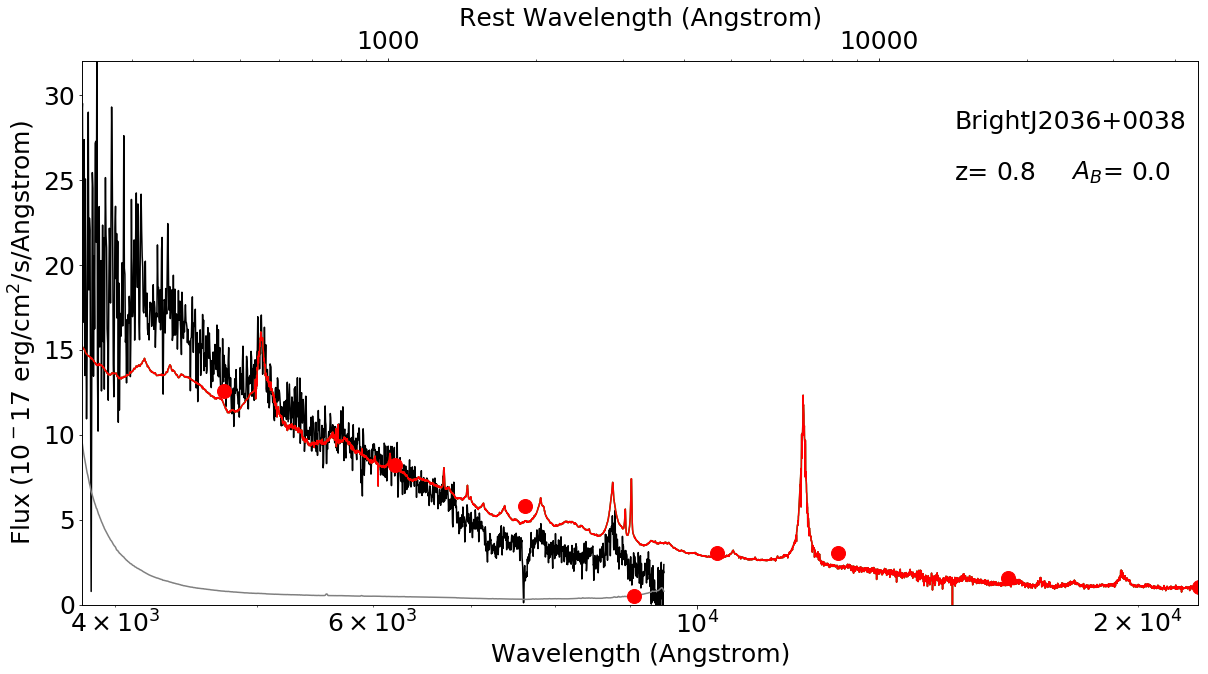

('BrightJ2323+0057', 2.73, 0.4, 0.0365716964113483, 7.340731340195562)


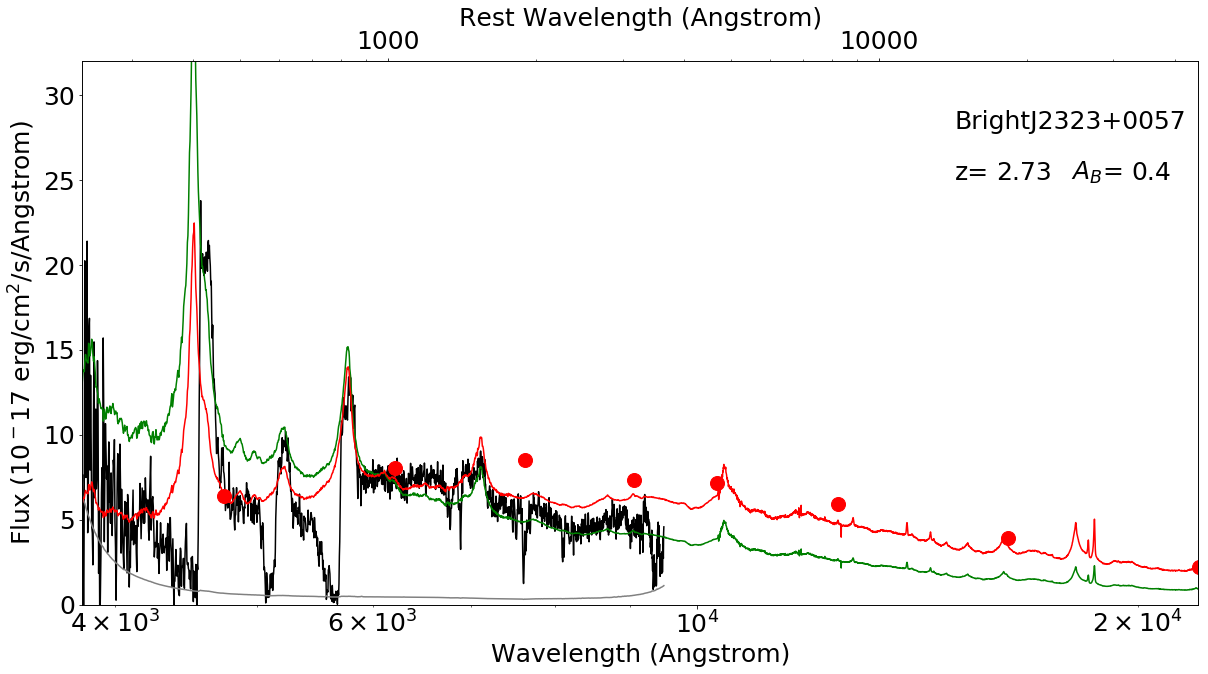

('BrightJ2103-0043', 2.15, 0.0, 0.059561488788307804, 24.57592898206955)


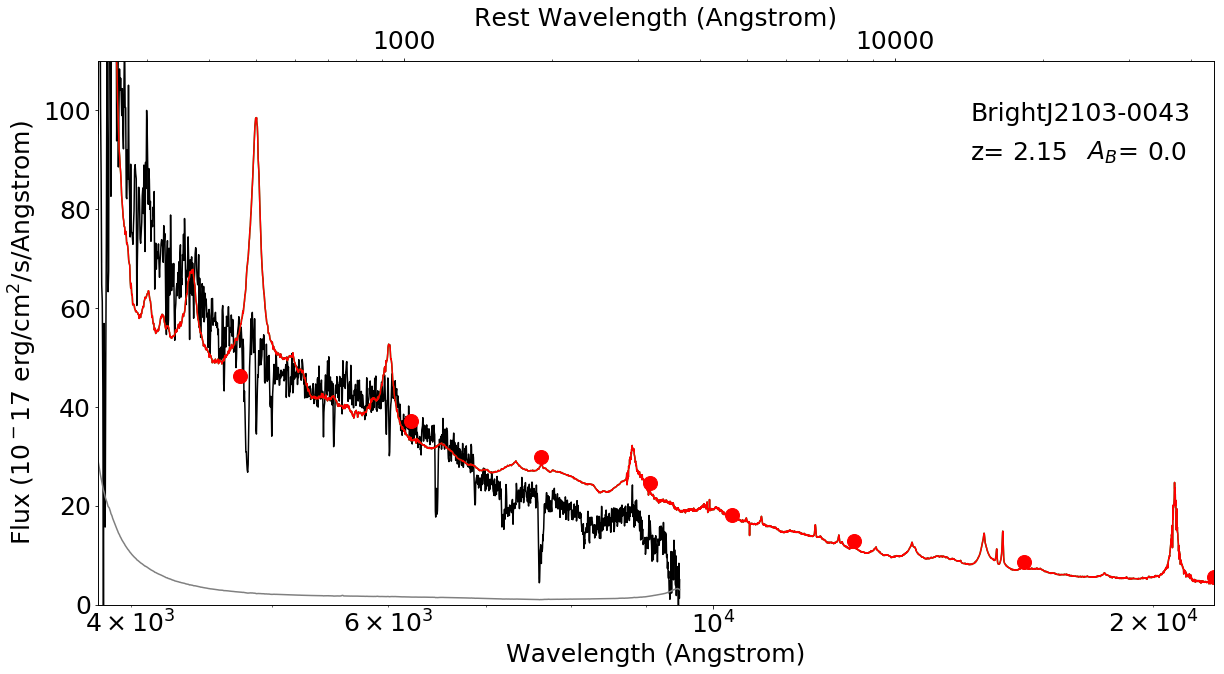

('BrightJ2241-0103', 1.12, 0.0, 0.04960500779295583, 6.72634612884291)


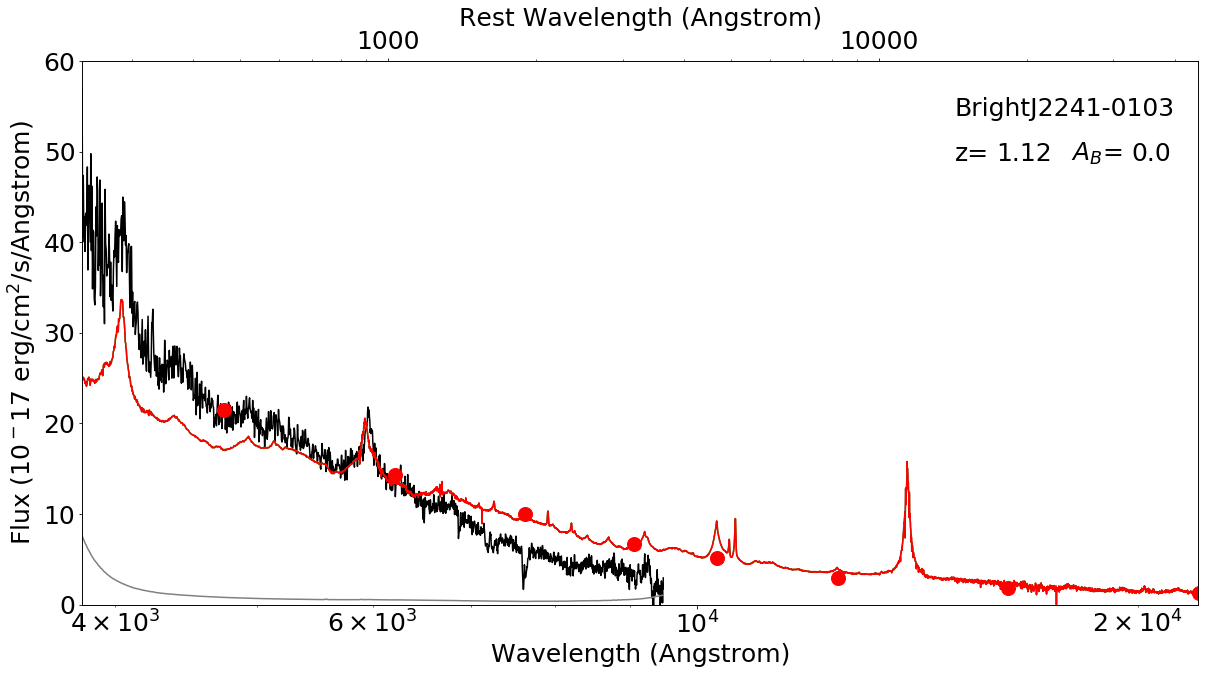

('BrightJ2259+0103', 1.29, 0.0, 0.051731370870376825, 5.130508204698571)


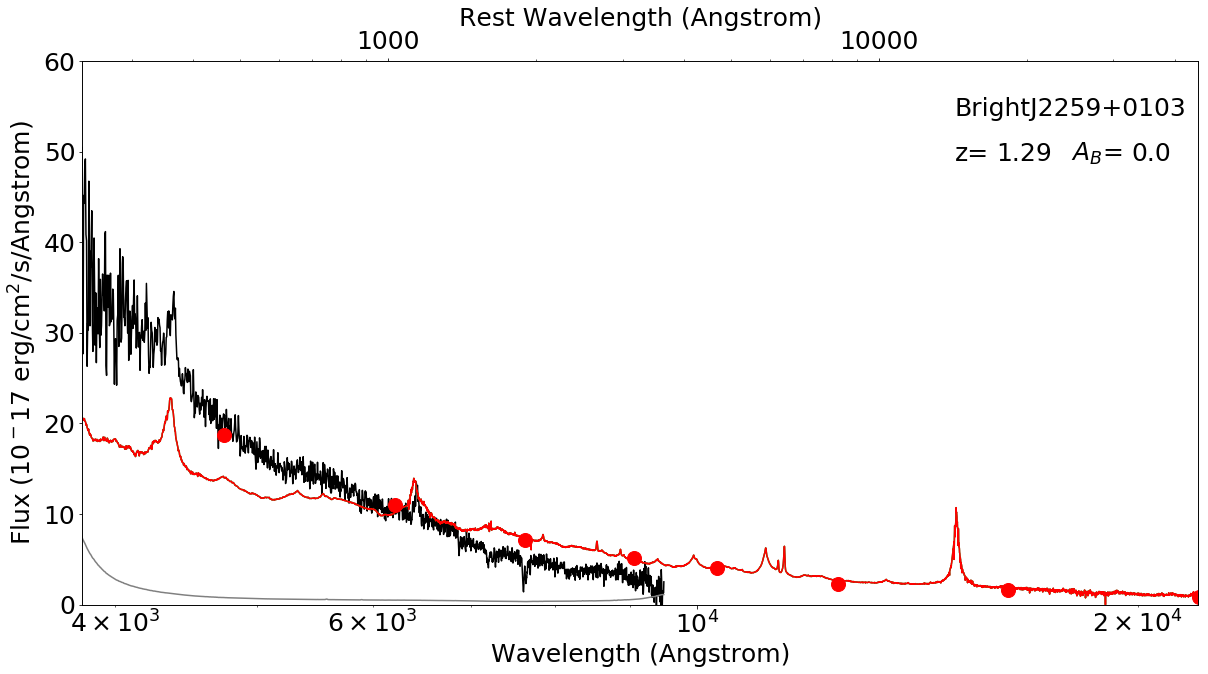

('BrightJ2043+0045', 2.46, 0.0, 0.06194622856156105, 5.626452332716868)


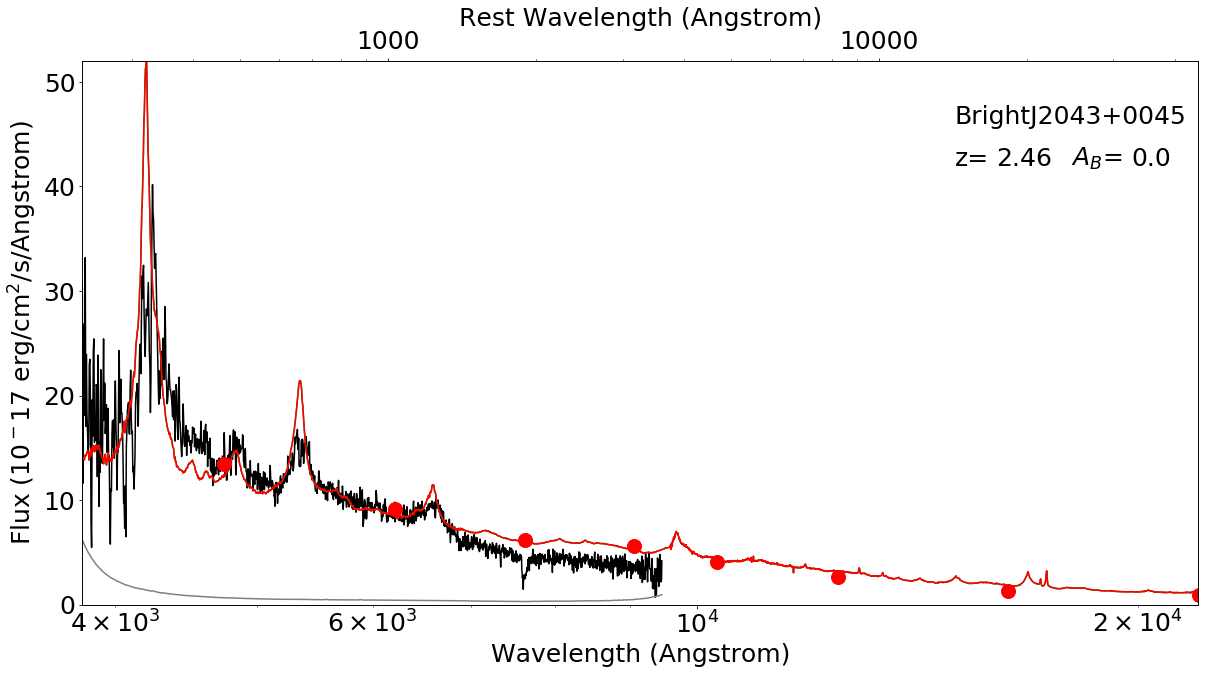

('RedJ0000+0032', 2.6, 0.2, 0.02230384269030038, 4.343238428267874)


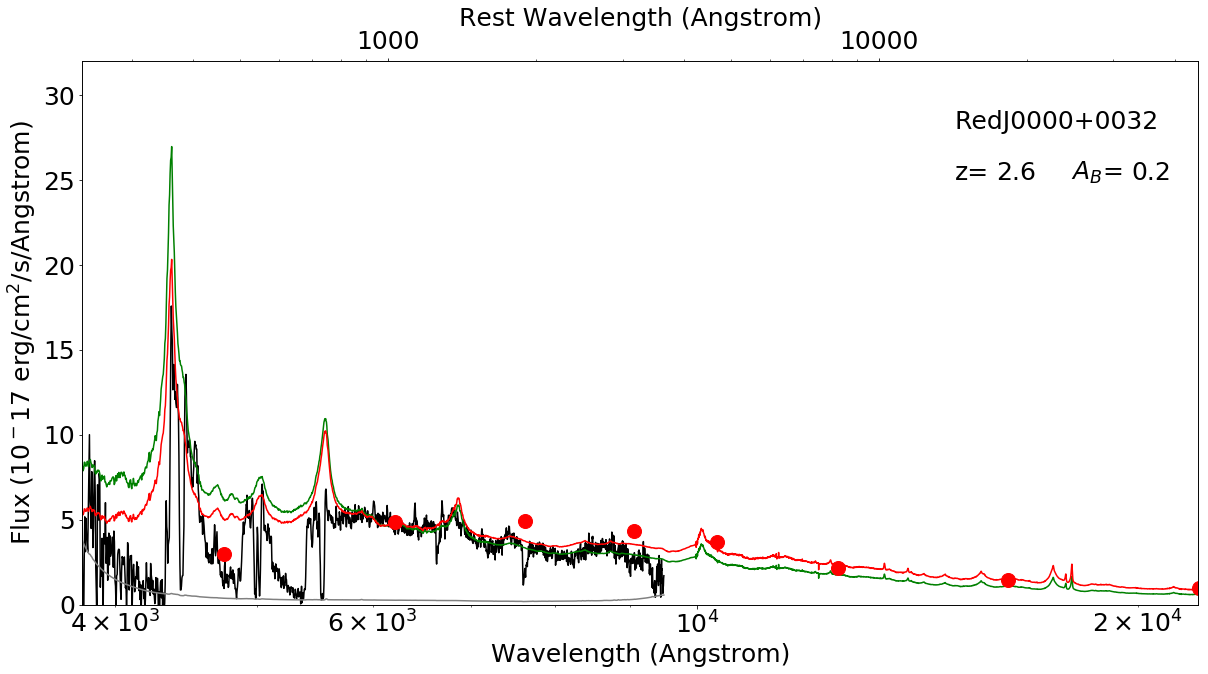

('RedJ2056+0032', 1.98, 1.2, 0.07065293080133431, 11.062954726717932)


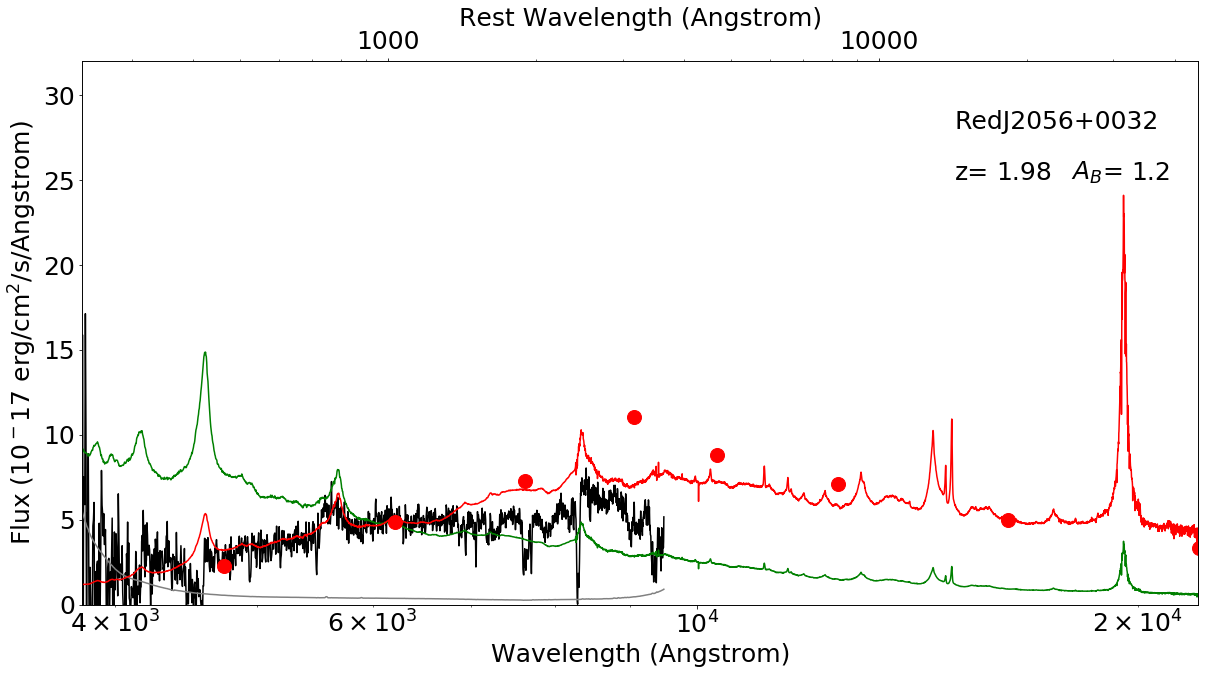

('RedJ2045-0022', 1.15, 0.4, 0.05684404707505675, 12.746778231970222)


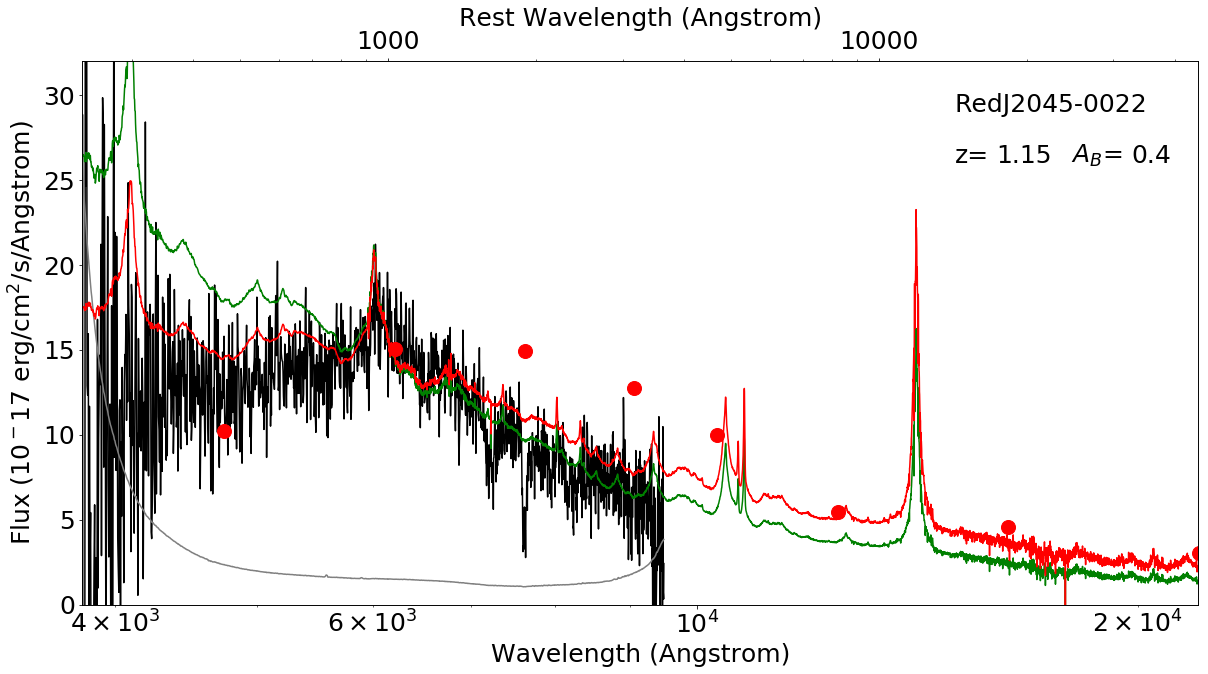

('RedJ2047+0045', 2.3, 0.0, 0.09452380942998732, 10.354548908103947)


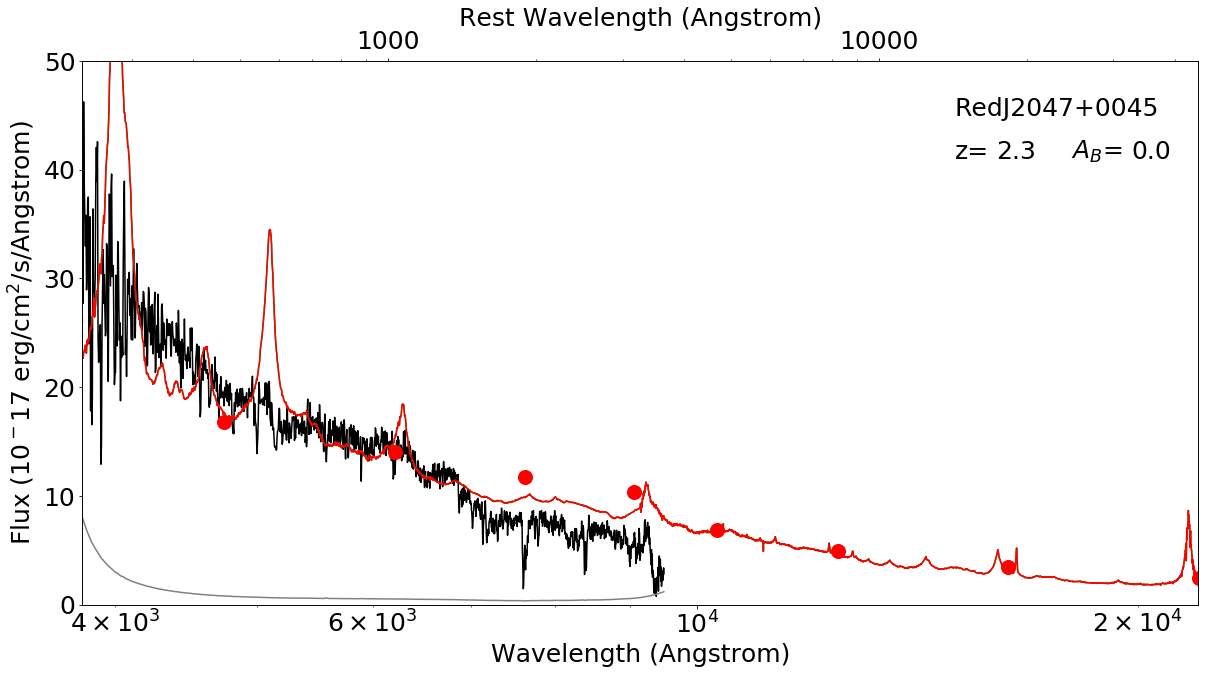

('RedJ2120-0020', 1.52, 0.6, 0.04266977734983571, 8.732253933102063)


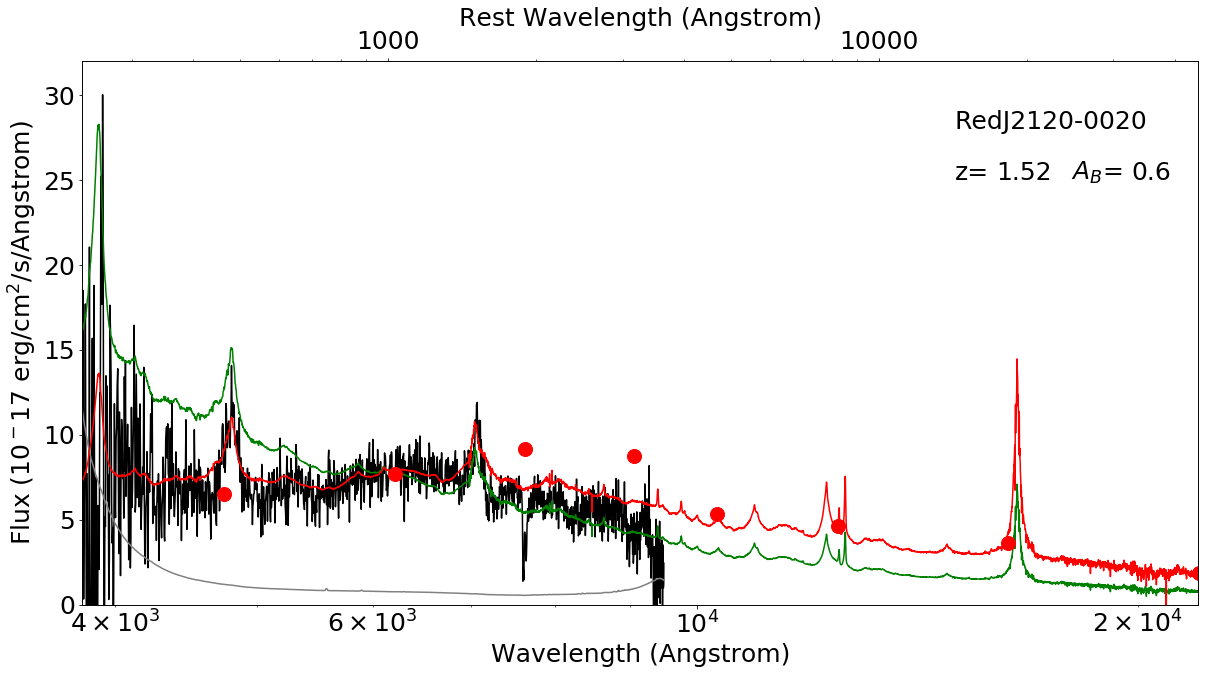

('RedJ2203-0052', 1.25, 0.4, 0.062313790828069524, 5.166999520752223)


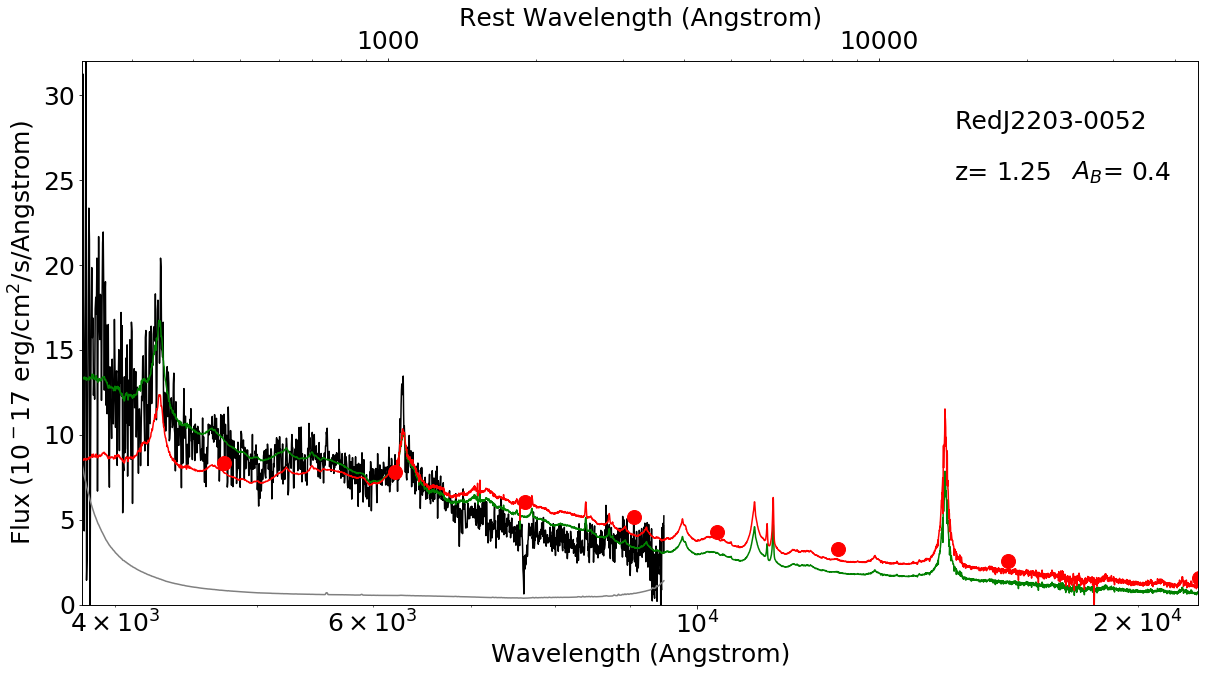

('RedJ2113-0028', 2.48, 0.0, 0.05579025955733443, 2.635211402274445)


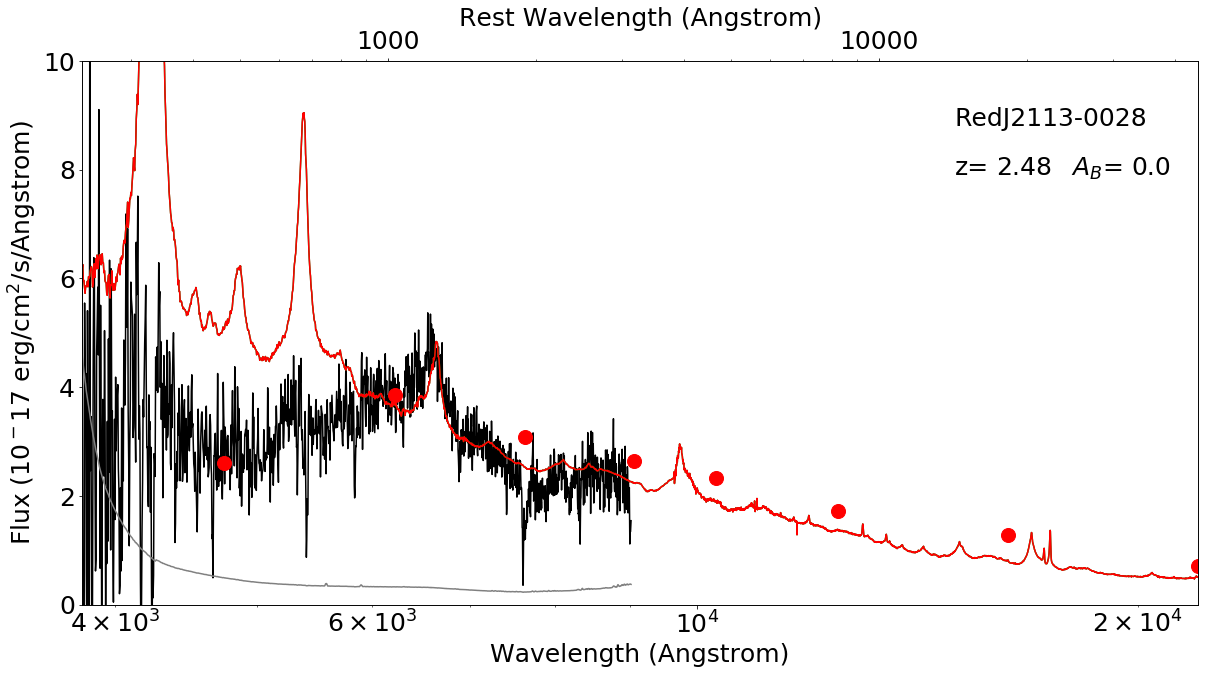

('RedJ2042-0039', 2.36, 0.0, 0.05165630255562019, 4.052459532594922)


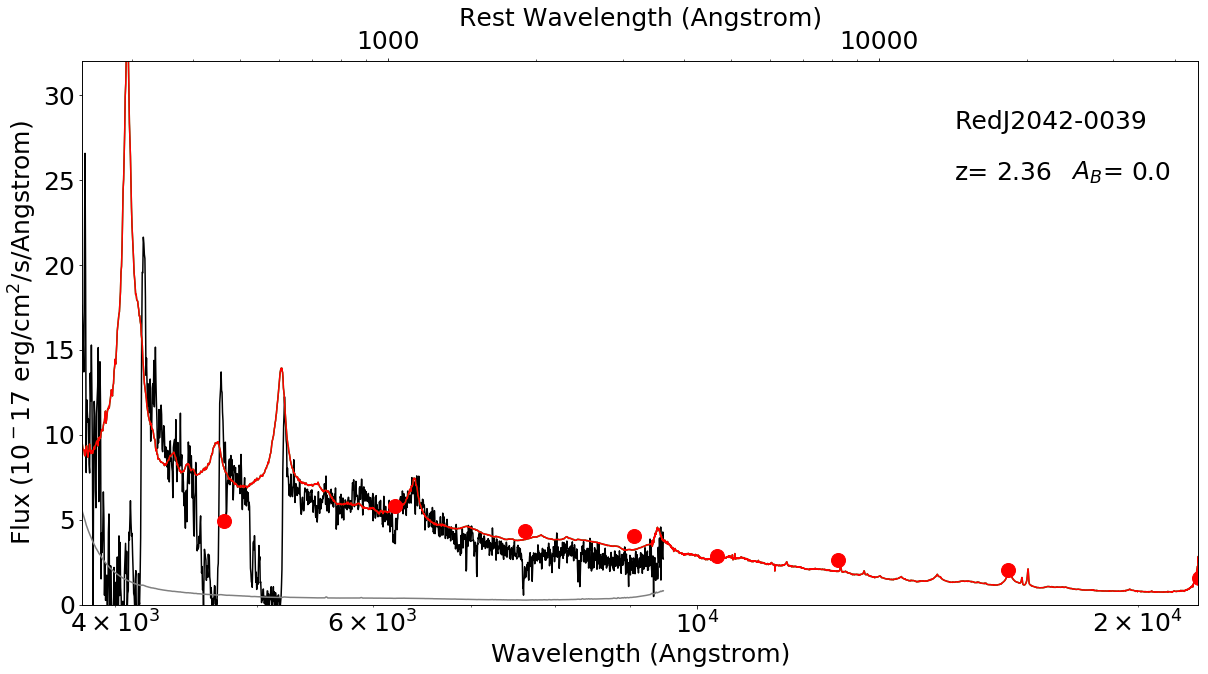

('RedJ2048+0056', 2.37, 0.4, 0.08200064569678303, 4.539151562038838)


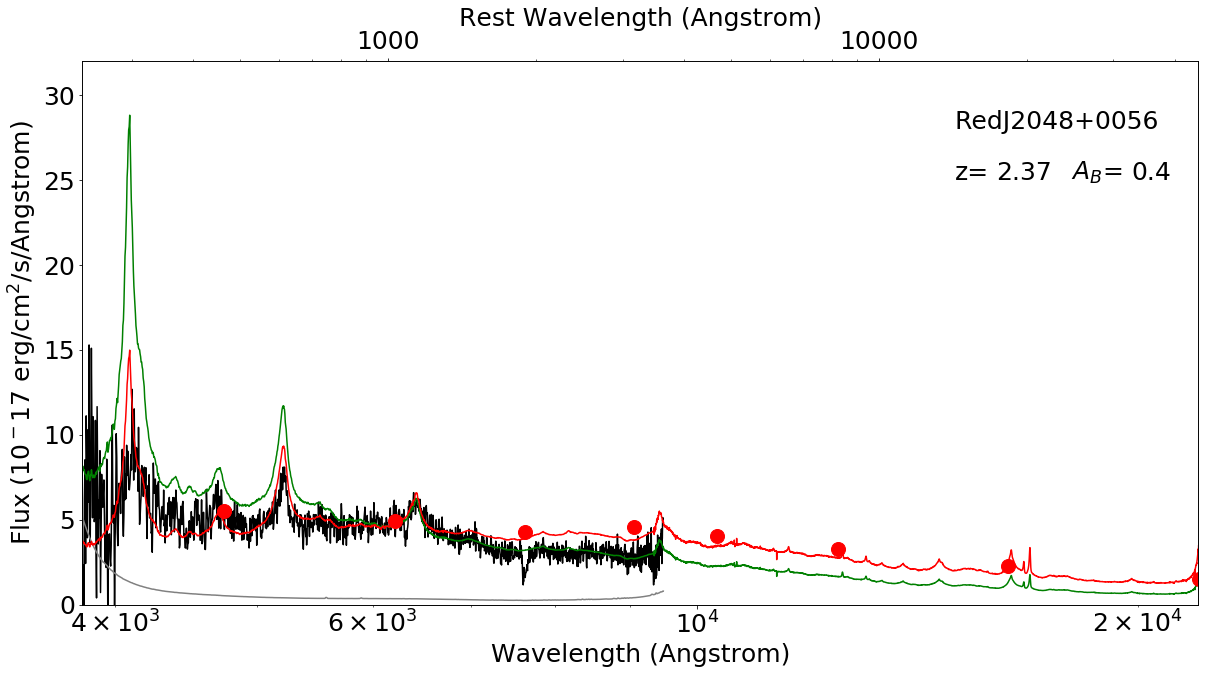

('RedJ0312+0032', 1.25, 0.5, 0.07271453481118151, 3.961104836140404)


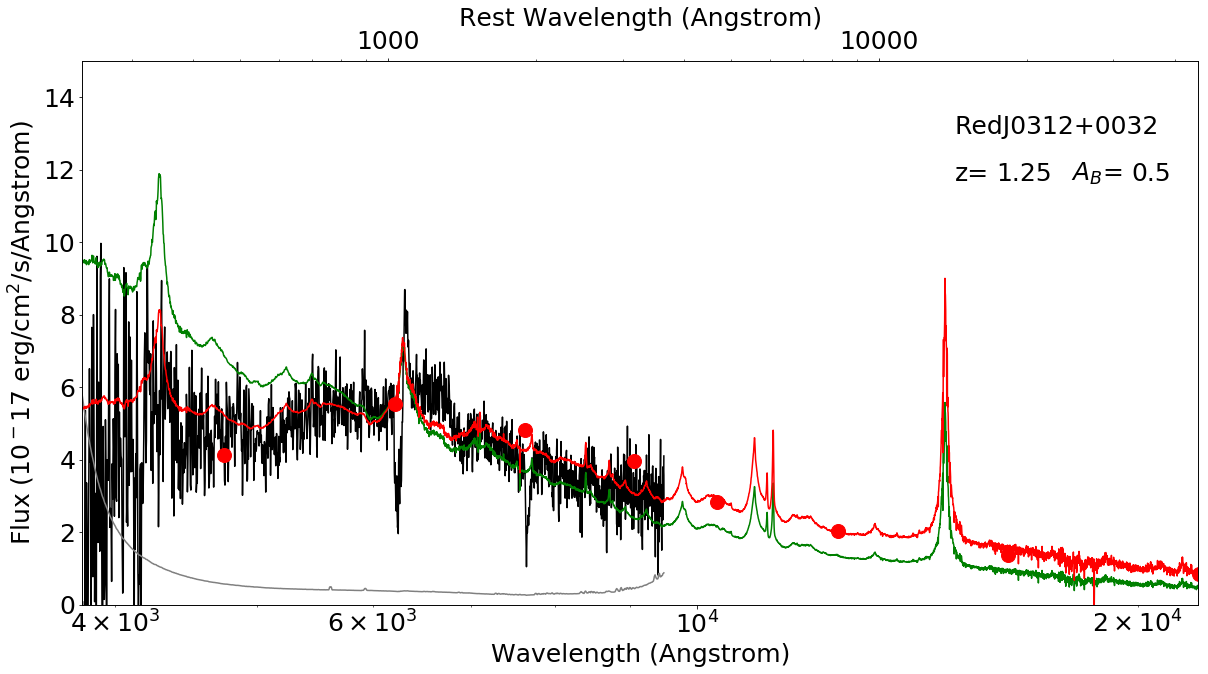

('RedJ0312+0035', 1.28, 1.1, 0.07324730161761739, 3.5457807974242748)


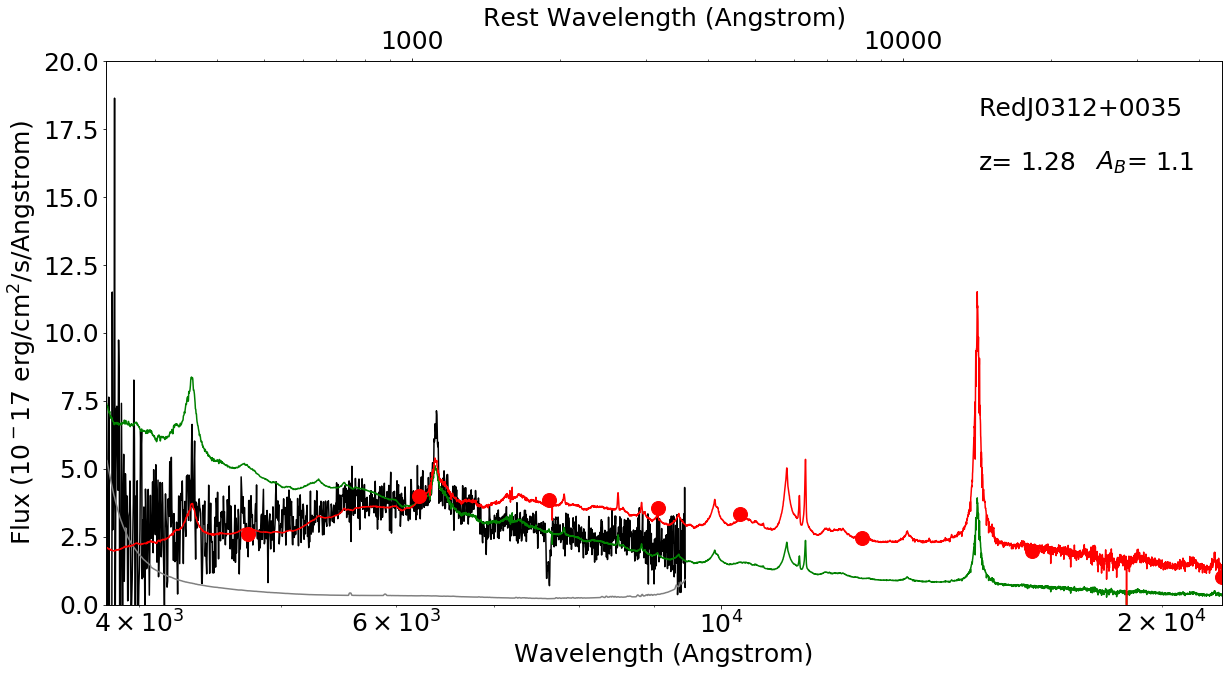

('RedJ2320+0028', 0.0, 0.0, 0.040367691803819016, 4.117636164416992)


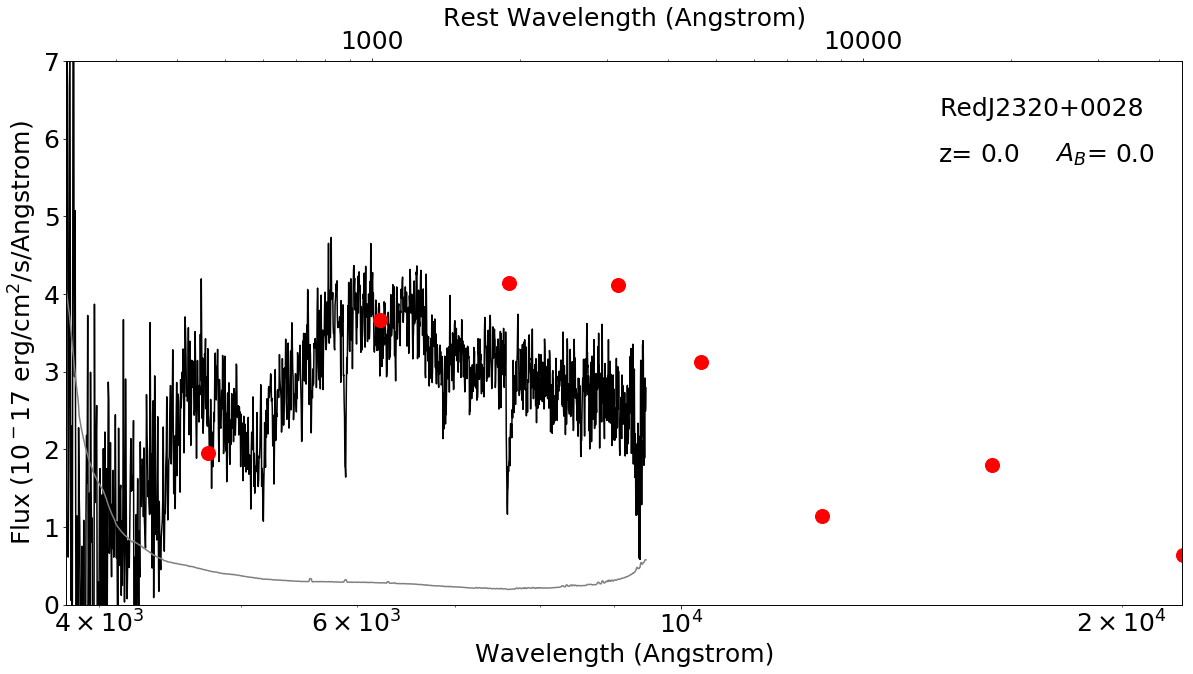

In [9]:
# coding: utf-8

#Libraries for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

#Standard numerical and scientific libraries
import numpy as np
import scipy as sp

#Units, Constants, Fits reading libraries
from astropy import units as U
from astropy import constants as C
from astropy.io import fits
from astropy.io import ascii

#Automatic spectra reading tools
from specutils.io import read_fits

#Astronomy related packages
from PyAstronomy import pyasl
from specutils import extinction

import sfdmap  # SFD dust maps 

from decimal import Decimal #convert to decimals

from string import rstrip

from matplotlib import rc   #for Latex text


#Load files:
mags = np.loadtxt("/home/christina/Desktop/QSOs/mags.list")     #magnitude list
comp_file=np.loadtxt('/home/christina/Desktop/QSOs/compoM.data')   #composite spectrum
zab = np.loadtxt("/home/christina/Desktop/QSOs/zab1.list")
names = np.loadtxt("/home/christina/Desktop/QSOs/names.list", dtype=np.str)

AB=zab[:,1]
z=zab[:,0]

wlr=comp_file[:,0]/1e4   #wavelength of composite spectrum in microns  (rest frame)
flx=comp_file[:,1]   #flux of composite spectrum

#Read the coordinates:
f = open("/home/christina/Desktop/QSOs/coord.list", "r")
e=open("/home/christina/Desktop/QSOs/ebv.list", "w")    #open file to write 
rah,decd = [], []
for l in f:
    row = l.split()
    rah = row[0]
    decd = row[1]
    coor= np.array([rah,decd])
    a=' '.join(coor)
    ra, dec = pyasl.coordsSexaToDeg(a)
    m = sfdmap.SFDMap('/home/christina/Desktop/QSOs/Dust/')
    ebv = m.ebv(ra, dec, frame='icrs', interpolate=True)
    b=(''.join(str(ebv)))
    e.write("%s\n" % b)       #write ebv values to list file
    for row in str(ebv):
        b=(''.join(str(ebv)))
e.close()

ebv = np.loadtxt('/home/christina/Desktop/QSOs/ebv.list')


#Parameters for the Pei-parametrization of the SMC extinction curve
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])

### Central wavelengths for broad band filters (Aangstrom)
lambdau=3540.
lambdag=4750.
lambdar=6220.
lambdai=7630.
lambdaz=9050.
lambday=10310.
lambdaj=12480.
lambdah=16310.
lambdak=22010.
#Build an array with the wavelengths
wavar=np.array([lambdau, lambdag, lambdar, lambdai, lambdaz, lambday, lambdaj,lambdah, lambdak])  

#The magnitudes
u = mags[:,0]
g = mags[:,1]
r = mags[:,2]
i = mags[:,3]
zs = mags[:,4] #zs in order to not confuse with the redshift
y = mags[:,5]
j = mags[:,6]
h = mags[:,7]
k = mags[:,8]
#Build an array with the magnitudes
magsar=np.array([u,g,r,i,zs,y,j,h,k])
            
#Now run through the Nspec spectra
Nspec=18

list = open('/home/christina/Desktop/QSOs/redspec1.list')

wavelength = np.zeros((Nspec),float)
flux = np.zeros((Nspec),float)

for s in range(0,Nspec):
    spec = fits.open(rstrip(list.readline()))
    Header = spec[0].header
    flux = spec[0].data*1e17
    lambda_central = Header['CRVAL1']
    delta_lambda = Header['CD1_1']
    Naxis1 = spec[0].header['NAXIS1']
    wavelength = delta_lambda*np.arange(0,Naxis1)+lambda_central
    fluxe=flux[3]   #error specrum flux
    #print fluxe
    flux=flux[0]
    
    #Convert mags to flux for each filter:
    fluxu = 10.**(0.4*(-48.60-u[s]))*3.e18/lambdau**2    
    fluxg = 10.**(0.4*(-48.60-g[s]))*3.e18/lambdag**2
    fluxr = 10.**(0.4*(-48.60-r[s]))*3.e18/lambdar**2
    fluxi = 10.**(0.4*(-48.60-i[s]))*3.e18/lambdai**2
    fluxz = 10.**(0.4*(-48.60-zs[s]))*3.e18/lambdaz**2
    fluxy = 10.**(0.4*(-48.60-y[s]))*3.e18/lambday**2
    fluxj = 10.**(0.4*(-48.60-j[s]))*3.e18/lambdaj**2
    fluxh = 10.**(0.4*(-48.60-h[s]))*3.e18/lambdah**2
    fluxk = 10.**(0.4*(-48.60-k[s]))*3.e18/lambdak**2
    #convert to array
    fluxar=np.array([fluxu, fluxg, fluxr, fluxi, fluxz, fluxy, fluxj,fluxh, fluxk])  
    AB=zab[:,1]
    ABn= AB[s]
    
    #Correct for galactic extinction
    funred = pyasl.unred(wavelength, flux[0], ebv[s])
    deredr = pyasl.unred(wavar, fluxar, ebv[s])
    spec = spec[0]
    spec = funred
    filt = np.nonzero((wavelength*U.Angstrom > (5700*U.Angstrom)) & (wavelength*U.Angstrom < (6600*U.Angstrom)))
    norm = np.mean(spec[filt])
    specr = funred/norm*deredr[2]*1.e17    #Scaling spectrum tor the r-band--the index 2 refers to the r-band

    z=zab[:,0]
    zn=z[s]
    
    wl=comp_file[:,0]*(zn+1.)   #wavelength of composite spectrum
    flx=comp_file[:,1]    #flux of composite spectrum

    filtc = np.nonzero((wl*U.Angstrom > (5700*U.Angstrom)) & (wl*U.Angstrom < (6600*U.Angstrom)))
    normc=np.mean(flx[filtc])       #normalized flux of comp spec without reddening
    
    #Correct the reddened composite spectrum for SMC reddening: 
    Alambda = flx*0.      #Reset flux to zero
    for e in range(len(ai)):
        Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])   #fitting function covering all wavelengths in microns
    Alambda = Alambda*ABn
    model = 10**(-0.4*Alambda)*flx    #use the flux of the composite spectrum
   # wl=comp_file[:,0]*(z+1.)   #wavelength of the composite spectrum
    flt = np.nonzero((wl*U.Angstrom > (5700*U.Angstrom)) & (wl*U.Angstrom < (6600*U.Angstrom)))
    normm = np.mean(model[flt])

    #Error Spectrum
    
    funrede = pyasl.unred(wavelength, fluxe[0], ebv[s])
    #spece = spec[0]
    spece = funrede
    spece = fluxe/norm*deredr[2]*1e17   #Scale error spectrum to r-band
    spece=spece[0]
    
    ########## PLOT ############
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax1=fig.add_subplot(111)
    ax2=fig.add_subplot(111) 
    ax3=fig.add_subplot(111) 
    ax4=fig.add_subplot(111) 
    ax5=fig.add_subplot(111) 

    ax.set_xlabel("Wavelength (Angstrom)", fontsize=25)
    ax.set_ylabel("Flux (10$^-17$ erg/cm$^2$/s/Angstrom)",fontsize=25)
    ax.set_xlim([3800,22000])
    #locs = np.array([5000, 10000,20000])
    #ax.set_xticks(locs)
    #ax.set_xticklabels(locs)
    ax.tick_params(axis='both', which='both', labelsize=25)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    #ax.ticklabel_format(axis='both', style='plain', useOffset=False)
    
    #ax.ticklabel_format(axis='x', style='plain', useOffset= False)
    #ax.set_xticks([5000, 10000, 20000])
    #ax.xaxis.set_major_formatter(ScalarFormatter())
    #ax.set_xticklabels(['5000','10000','20000'])
    #plt.xticks(range(3), ('5000', '10000', '20000'))
    #ax.set_xticklabels([4000, 5500, 7500, 10500, 14500, 20000])
    #ax.set_xticks([4000, 5500, 7500, 10500, 14500, 20000])
    if names[s] == str('BrightJ2103-0043'):
        plt.text(15000,98,names[s], fontsize=25)
        plt.text(15000,90, 'z=', fontsize=25)
        plt.text(16000,90,zn, fontsize=25)
        plt.text(18000,90,r'$A_B$=', fontsize=25)
        plt.text(19800,90,ABn, fontsize=25)
        #ax.axis([3800,22000,0,110])
        ax.set_ylim([0,110])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('RedJ2113-0028'):
        plt.text(15000,8.8,names[s], fontsize=25)
        plt.text(15000,7.9, 'z=', fontsize=25)
        plt.text(16000,7.9,zn, fontsize=25)
        plt.text(18000,7.9,r'$A_B$=', fontsize=25)
        plt.text(19800,7.9,ABn, fontsize=25)
        ax.set_ylim([0,10])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('RedJ2045-0022'):
        plt.text(15000,29,names[s], fontsize=25)
        plt.text(15000,26, 'z=', fontsize=25)
        plt.text(16000,26,zn, fontsize=25)
        plt.text(18000,26,r'$A_B$=', fontsize=25)
        plt.text(19800,26,ABn, fontsize=25)
        ax.set_ylim([0,32])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('RedJ0312+0032'):
        plt.text(15000,13,names[s], fontsize=25)
        plt.text(15000,11.7, 'z=', fontsize=25)
        plt.text(16000,11.7,zn, fontsize=25)
        plt.text(18000,11.7,r'$A_B$=', fontsize=25)
        plt.text(19800,11.7,ABn, fontsize=25)
        ax.set_ylim([0,15])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('RedJ0312+0035'):
        plt.text(15000,18,names[s], fontsize=25)
        plt.text(15000,16, 'z=', fontsize=25)
        plt.text(16000,16,zn, fontsize=25)
        plt.text(18000,16,r'$A_B$=', fontsize=25)
        plt.text(19800,16,ABn, fontsize=25)
        ax.set_ylim([0,20]) 
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('BrightJ2241-0103'):
        plt.text(15000,54,names[s], fontsize=25)
        plt.text(15000,49, 'z=', fontsize=25)
        plt.text(16000,49,zn, fontsize=25)
        plt.text(18000,49,r'$A_B$=', fontsize=25)
        plt.text(19800,49,ABn, fontsize=25)
        ax.set_ylim([0,60])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('BrightJ2259+0103'):
        plt.text(15000,54,names[s], fontsize=25)
        plt.text(15000,49, 'z=', fontsize=25)
        plt.text(16000,49,zn, fontsize=25)
        plt.text(18000,49,r'$A_B$=', fontsize=25)
        plt.text(19800,49,ABn, fontsize=25)
        ax.set_ylim([0,60])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('RedJ2320+0028'):
        plt.text(15000,6.3,names[s], fontsize=25)
        plt.text(15000,5.7, 'z=', fontsize=25)
        plt.text(16000,5.7,zn, fontsize=25)
        plt.text(18000,5.7,r'$A_B$=', fontsize=25)
        plt.text(19800,5.7,ABn, fontsize=25)
        ax.set_ylim([0,7])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
    elif names[s] == str('RedJ2047+0045'):
        plt.text(15000,45,names[s], fontsize=25)
        plt.text(15000,41, 'z=', fontsize=25)
        plt.text(16000,41,zn, fontsize=25)
        plt.text(18000,41,r'$A_B$=', fontsize=25)
        plt.text(19800,41,ABn, fontsize=25)
        ax.set_ylim([0,50])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    elif names[s] == str('BrightJ2043+0045'):
        plt.text(15000,46,names[s], fontsize=25)
        plt.text(15000,42, 'z=', fontsize=25)
        plt.text(16000,42,zn, fontsize=25)
        plt.text(18000,42,r'$A_B$=', fontsize=25)
        plt.text(19800,42,ABn, fontsize=25)
        ax.set_ylim([0,52])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
        
        
    #elif names[s] == str('RedJ2048+0056'):
        #plt.text(15000,28,names[s], fontsize=25)
        #plt.text(5223,12, 'CIV', fontsize='20')
        #plt.text(4200,15, r'Ly-$\alpha$', fontsize='20')
        #plt.text(6436,15, r'CIII', fontsize='20')
        #plt.text(4720,15, r'SiIV', fontsize='20')
        #plt.text(15000,25, 'z=', fontsize=25)
        #plt.text(16000,25,zn, fontsize=25)
        #plt.text(18000,25,r'$A_B$=', fontsize=25)
        #plt.text(19800,25,ABn, fontsize=25)
        #ax.axis([3800,22000,0,32])
        #ax.semilogx(wavelength,specr,'k')
        #ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        #ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        #ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        #ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
        #l1=[5214,5214]
        #l2=[6.5,32]
        #l3=[4092,4092]
        #l4=[6.5,32]
        #l5=[6429,6429]
        #l6=[6.5,32]
        #l7=[4715,4715]
        #l8=[6.5,32]
        #plt.plot(l1,l2,'--', color = 'grey')
        #plt.plot(l3,l4,'--', color = 'grey')
        #plt.plot(l5,l6,'--', color = 'grey')
        #plt.plot(l7,l8,'--', color = 'grey')
        #plt.savefig("/home/christina/Desktop/QSOs/Figures/RedJ2048c.pdf") 
    else:
        plt.text(15000,28,names[s], fontsize=25)
        plt.text(15000,25, 'z=', fontsize=25)
        plt.text(16000,25, zn, fontsize=25)
        plt.text(18000,25,r'$A_B$=', fontsize=25)
        plt.text(19800,25,ABn, fontsize=25)
        ax.set_ylim([0,32])
        ax.semilogx(wavelength,specr,'k')
        ax1.semilogx(wavelength,spece,color='grey')    #error spectrum
        ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
        ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
        ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    
    print(names[s],z[s],AB[s],ebv[s],deredr[4]*1.e17)
 
   #Composite spectrum
    ax2=ax.twiny()
    #ax2.xticks([1000,2000,3000,4000,5000],fontsize=14)
    wln=comp_file[:,0]
    
    ax2.semilogx(wln,flx/normc*deredr[2]*1.e17, color='white',linestyle="None")
    ax2.set_xlabel("Rest Wavelength (Angstrom)", fontsize=25)
    ax2.xaxis.set_major_formatter(ScalarFormatter())
    ax2.ticklabel_format(axis='both', style='plain', fontsize=25)
    plt.xticks(fontsize=25)
    #plt.setp(ax,xticks=[5000, 10000, 20000], xticklabels=['5000', '10000', '20000']) 
    #ax2.set_xticks(np.arange(3), ('1000', '2000', '5000'))
    #ax3.semilogx(wl,flx/normc*deredr[2]*1.e17,'g')   #composite spectrum without SMC reddening
    #ax4.semilogx(wavar, deredr*1e17, 'ro', markersize=14)   #photometric points 
    #ax5.semilogx(wl, model/normm*deredr[2]*1.e17,'r')    #composite spectrum with SMC reddening
    plt.savefig("/home/christina/Desktop/QSOs/Figures/"+ names[s] + '.pdf')
    plt.show()
list.close()